In [ ]:
"""
Created on Thu Oct 24 09:54 2024

Try to prepare grid for remapcon using xesmf

@author: Clara Burgard
"""

In [10]:
import xarray as xr
import xesmf
import numpy as np

In [60]:
%matplotlib qt5

QStandardPaths: error creating runtime directory '/run/user/2784' (Permission denied)


In [3]:
inputpath = '/data/cburgard/PREPARE_FORCING/PREPARE_CAVITY_MASKS/interim/'

In [4]:
# Load your curvilinear grid file
ds = xr.open_dataset(inputpath + 'grid_eORCA1_T.nc')

In [5]:
ds

<xarray.Dataset>
Dimensions:  (y: 331, x: 360)
Coordinates:
    glamt    (y, x) float64 ...
    gphit    (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables:
    dummy    (y, x) int8 ...
Attributes:
    NCO:      netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, C...
    history:  Mon Oct 21 17:25:25 2024: ncatted -a coordinates,dummy,c,c,glam...

In [62]:
# Assuming the dataset has 'lat' and 'lon' variables
lat = ds['gphit']  # 2D array of latitudes
lon = ds['glamt'] # 2D array of longitudes

In [8]:
# Generate cell corner coordinates for the curvilinear grid
grid_with_corners = xesmf.util.add_corner(ds, periodic=True)

AttributeError: module 'xesmf.util' has no attribute 'add_corner'

In [14]:
meshlon,meshlat = np.meshgrid(ds.x,ds.y)

In [53]:
-180 - 180

-360

In [23]:
lat - mid

<xarray.DataArray 'gphit' (y: 331, x: 360)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       ...,
       [-0.11048269, -0.13902775, -0.15208429, ...,  0.13902775,
         0.11048269,         nan],
       [-0.10969223, -0.13897153, -0.15209262, ...,  0.13897153,
         0.10969223,         nan],
       [-0.10921082, -0.13895141, -0.15209963, ...,  0.13895141,
         0.10921082,         nan]])
Coordinates:
    glamt    (y, x) float64 73.5 74.5 75.5 76.5 77.5 ... 72.93 72.95 72.96 72.99
    gphit    (y, x) float64 -84.21 -84.21 -84.21 -84.21 ... 50.51 50.23 50.01
Dimensions without coordinates: y, x

In [22]:
mid = (lat + lat.shift(x=-1))/2

In [25]:
meshlon_ll,meshlat_ll = (lon + lon.shift(x=-1))/2, (meshlat + lat.shift(x=-1))/2
meshlon_lr,meshlat_lr = (lon + lon.shift(x=1))/2, (meshlat + lat.shift(x=-1))/2
meshlon_ur,meshlat_ur = (lon + lon.shift(x=1))/2, (meshlat + lat.shift(x=1))/2
meshlon_ul,meshlat_ul = (lon + lon.shift(x=-1))/2, (meshlat + lat.shift(x=1))/2

In [56]:
meshlon360_ll,meshlat360_ll = (lon360 + lon360.shift(x=-1))/2, (meshlat + lat.shift(x=-1))/2
meshlon360_lr,meshlat360_lr = (lon360 + lon360.shift(x=1))/2, (meshlat + lat.shift(x=-1))/2
meshlon360_ur,meshlat360_ur = (lon360 + lon360.shift(x=1))/2, (meshlat + lat.shift(x=1))/2
meshlon360_ul,meshlat360_ul = (lon360 + lon360.shift(x=-1))/2, (meshlat + lat.shift(x=1))/2

In [27]:
lon_bnds = xr.DataArray(data=np.array([meshlon_ll, meshlon_lr, meshlon_ur, meshlon_ul]), dims=['nvertex','y','x'])
lat_bnds = xr.DataArray(data=np.array([meshlat_ll, meshlat_lr, meshlat_ur, meshlat_ul]), dims=['nvertex','y','x'])

In [57]:
lon360_bnds = xr.DataArray(data=np.array([meshlon360_ll, meshlon360_lr, meshlon360_ur, meshlon360_ul]), dims=['nvertex','y','x'])
lat360_bnds = xr.DataArray(data=np.array([meshlat360_ll, meshlat360_lr, meshlat360_ur, meshlat360_ul]), dims=['nvertex','y','x'])

In [31]:
NEMO_new_grid = xr.merge([lon_bnds.rename('lon_bnds'),lat_bnds.rename('lat_bnds')]).assign_coords({'lon': lon, 'lat': lat}).drop('glamt').drop('gphit')

In [32]:
NEMO_new_grid['lon'].attrs['standard_name'] = 'longitude'
NEMO_new_grid['lon'].attrs['units'] = 'degrees_east'
NEMO_new_grid['lon'].attrs['bounds'] = 'lon_bnds'

NEMO_new_grid['lat'].attrs['standard_name'] = 'latitude'
NEMO_new_grid['lat'].attrs['units'] = 'degrees_north'
NEMO_new_grid['lat'].attrs['bounds'] = 'lat_bnds'


In [38]:
NEMO_new_grid[['lon','lat','lon_bnds','lat_bnds']].set_coords(("lat_bnds", "lon_bnds")).transpose('y','x','nvertex').to_netcdf(inputpath + 'NEMO_grid_withbnds.nc')

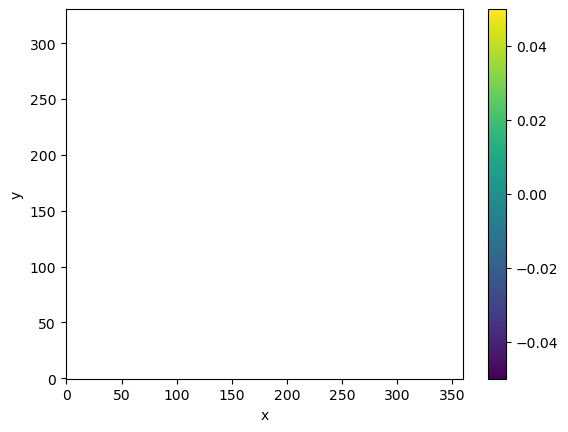

In [58]:
lon_bnds.where(lat_bnds == 0).isel(nvertex=2).plot()

In [96]:
lon_bnds.where((lon >= -179.95) & (lon <= 179.95)).isel(nvertex=1).plot() #(lon_bnds > 4) &

In [74]:
lon_bnds.isel(nvertex=1).plot()

In [70]:
lon.max()

<xarray.DataArray 'glamt' ()>
array(179.99031297)